# Semantle Notebook

In [ ]:
import os
import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from dotenv import load_dotenv
from openai import OpenAI

## Get Past Semantles

In [ ]:
past_semantles = []
nearby_words = []
num_games = 0
for i in range(1171):
  url = f"https://server.semantle.com/semantle/game-and-nearest/{i}/en"
  response = requests.get(url)
  try:
    data = json.loads(response.text)
  except json.JSONDecodeError:
    print(f"Error decoding JSON for game ID {i}: {response.text}")
    continue
  num_games += 1
  past_semantles.append(data['word'])
  for near in data['nearby']:
    nearby_words.append(near)

semantle_df = pd.DataFrame({
  'game_id': range(1, num_games+1),
  'answer': past_semantles,
  'nearby_1': [nearby_words[i] for i in range(0, len(nearby_words), 10)],
  'nearby_2': [nearby_words[i] for i in range(1, len(nearby_words), 10)],
  'nearby_3': [nearby_words[i] for i in range(2, len(nearby_words), 10)],
  'nearby_4': [nearby_words[i] for i in range(3, len(nearby_words), 10)],
  'nearby_5': [nearby_words[i] for i in range(4, len(nearby_words), 10)],
  'nearby_6': [nearby_words[i] for i in range(5, len(nearby_words), 10)],
  'nearby_7': [nearby_words[i] for i in range(6, len(nearby_words), 10)],
  'nearby_8': [nearby_words[i] for i in range(7, len(nearby_words), 10)],
  'nearby_9': [nearby_words[i] for i in range(8, len(nearby_words), 10)],
  'nearby_10': [nearby_words[i] for i in range(9, len(nearby_words), 10)]
})
semantle_df.to_csv('semantle.csv', index=False)
display(semantle_df)

Error decoding JSON for game ID 256: Game not found
Error decoding JSON for game ID 263: Game not found
Error decoding JSON for game ID 884: Game not found
Error decoding JSON for game ID 950: Game not found
Error decoding JSON for game ID 1007: Game not found


,answer,nearby_1,nearby_2,nearby_3,nearby_4,nearby_5,nearby_6,nearby_7,nearby_8,nearby_9,nearby_10
game_id,,,,,,,,,,,
1,forever,forevermore,eternally,irrevocably,eternity,indelibly,permanently,everlasting,eons,irreversibly,forgotten
2,executive,director,chairman,president,exec,chairperson,directors,vp,manager,honcho,chairwoman
3,elevator,elevators,escalator,stairwell,staircase,stairway,escalators,stairs,stairwells,dumbwaiter,stairways
4,patience,perseverance,fortitude,persevere,humility,prudence,diligence,tenacity,persistence,impatience,courage
5,overnight,morning,midday,afternoon,midmorning,midafternoon,day,night,hours,evening,daybreak
...,...,...,...,...,...,...,...,...,...,...,...
1162,substantial,significant,considerable,sizeable,sizable,appreciable,enormous,huge,minimal,large,negligible
1163,happiness,contentment,joy,contentedness,satisfaction,wholeness,prosperity,thankfulness,peacefulness,gladness,spirituality
1164,catch,catching,caught,catches,nab,snare,catchable,grab,hook,sneak,snared


In [21]:
# print total number of unique words across entire df
print(len(set(past_semantles + nearby_words)))

9839


In [5]:
model_google = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
model_google.similarity('happiness', 'oceanography')

0.060215086

In [17]:
row = semantle_df.iloc[0]
for i in range(1, 10):
  print(f"Game {row['game_id']}: {row['answer']}")
  print(f"Nearby word {i}: {row[f'nearby_{i}']}")
  print(f"Similarity: {model_google.similarity(row['answer'], row[f'nearby_{i}'])}")

Game 1: forever
Nearby word 1: forevermore
Similarity: 0.6128401160240173
Game 1: forever
Nearby word 2: eternally
Similarity: 0.5703619122505188
Game 1: forever
Nearby word 3: irrevocably
Similarity: 0.5341606140136719
Game 1: forever
Nearby word 4: eternity
Similarity: 0.5133062601089478
Game 1: forever
Nearby word 5: indelibly
Similarity: 0.5070809125900269
Game 1: forever
Nearby word 6: permanently
Similarity: 0.49701961874961853
Game 1: forever
Nearby word 7: everlasting
Similarity: 0.4943772554397583
Game 1: forever
Nearby word 8: eons
Similarity: 0.4937649071216583
Game 1: forever
Nearby word 9: irreversibly
Similarity: 0.4742991328239441


## ChatGPT Plays Semantle

In [2]:
semantle_df = pd.read_csv('semantle.csv', index_col=0)
display(semantle_df.head())

,answer,nearby_1,nearby_2,nearby_3,nearby_4,nearby_5,nearby_6,nearby_7,nearby_8,nearby_9,nearby_10
game_id,,,,,,,,,,,
1,forever,forevermore,eternally,irrevocably,eternity,indelibly,permanently,everlasting,eons,irreversibly,forgotten
2,executive,director,chairman,president,exec,chairperson,directors,vp,manager,honcho,chairwoman
3,elevator,elevators,escalator,stairwell,staircase,stairway,escalators,stairs,stairwells,dumbwaiter,stairways
4,patience,perseverance,fortitude,persevere,humility,prudence,diligence,tenacity,persistence,impatience,courage
5,overnight,morning,midday,afternoon,midmorning,midafternoon,day,night,hours,evening,daybreak


In [3]:
word_freq = pd.read_csv('count_1w.txt', sep='\t', header=None, names=['word', 'count'])
word_freq

,word,count
0,the,23135851162
1,of,13151942776
2,and,12997637966
3,to,12136980858
4,a,9081174698
...,...,...
333328,gooek,12711
333329,gooddg,12711
333330,gooblle,12711
333331,gollgo,12711


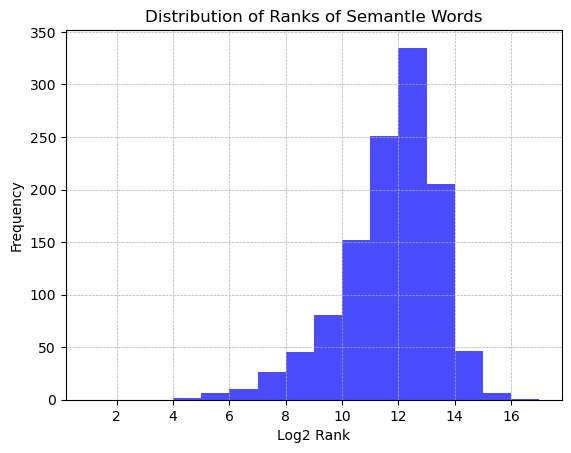

Mean rank: 5731.997427101201
Standard deviation of rank: 6376.697008027133
Minimum rank: 19
10th percentile: 697.0
20th percentile: 1425.0
30th percentile: 2289.0
40th percentile: 3202.0
50th percentile (median): 4190.0
60th percentile: 5267.0
70th percentile: 6832.0
80th percentile: 8654.0
90th percentile: 12211.5
Maximum rank: 102244


In [4]:
# find how common the words in semantle are by rank
rank = []
for word in semantle_df['answer']:
  rank.append(word_freq[word_freq['word'] == word].index[0] + 1)
semantle_df['rank'] = rank
semantle_df['log_rank'] = np.log2(semantle_df['rank'])

# plot histogram of ranks
plt.hist(semantle_df['log_rank'], bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], color='blue', alpha=0.7)
plt.title('Distribution of Ranks of Semantle Words')
plt.xlabel('Log2 Rank')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# print basic stats
print(f"Mean rank: {semantle_df['rank'].mean()}")
print(f"Standard deviation of rank: {semantle_df['rank'].std()}")
print(f"Minimum rank: {semantle_df['rank'].min()}")
for i in range(1, 10):
  if i != 5:
    print(f"{i*10}th percentile: {semantle_df['rank'].quantile(i/10)}")
  else:
    print(f"50th percentile (median): {semantle_df['rank'].median()}")
print(f"Maximum rank: {semantle_df['rank'].max()}")

In [5]:
display(semantle_df.sort_values(by='rank'))

,answer,nearby_1,nearby_2,nearby_3,nearby_4,nearby_5,nearby_6,nearby_7,nearby_8,nearby_9,nearby_10,rank,log_rank
game_id,,,,,,,,,,,,,
693,be,being,tobe,are,have,should,been,remain,were,is,probably,19,4.247928
714,your,you,yourself,yours,my,our,youre,yourselves,someones,their,bucko,24,4.584963
374,will,can,would,should,must,could,may,expects,continues,intends,expected,32,5.000000
973,if,unless,anyway,even,whether,not,might,probably,when,though,actually,37,5.209453
270,free,restricted,complimentary,freebie,gratis,unlimited,unfettered,unrestricted,freebies,discounted,preregistering,42,5.392317
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,uncomplicated,straightforward,simple,unfussy,uncluttered,effortless,intuitive,easy,unhurried,elegant,unostentatious,43534,15.409855
671,kneel,knelt,kneeling,kneeled,pray,kneels,sit,stare,genuflect,crouched,kissed,43769,15.417622
783,frustrate,stymie,unsettle,thwart,confound,befuddle,stifle,unnerve,fluster,hinder,embarrass,49040,15.581671


In [5]:
model_google = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
model_google.similarity('happiness', 'oceanography')

0.060215086

In [6]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [7]:
client = OpenAI(api_key=api_key)
description = "You are an assistant configured to solve a game of Semantle."
init_prompt = """
You are an assistant configured to solve a game of Semantle.
Your objective is to guess the secret word based on semantic similarity in as few guesses as possible.
You will provide a one word guess, and will continue until you find the secret word.

You may assume the following rules:
1. Semantle will inform you how semantically similar your guess is to the secret word.
2. Unlike other word games, this game is not about spelling; it's about meaning.
3. Word similarity is calculated using word2vec. If the word is within 1000 words of the secret word, you will be informed of this.
4. Once you get within one thousand words of the secret word, we will tell you in the proximity column.
5. You will be provided a list of words you previously guessed and their similarity scores. Do not repeat guesses.
6. In the early rounds, you should prioritize high-level concepts or semantic categories (e.g., "emotion", "animal", "tool"). In later rounds, you should narrow your guesses based on previous scores.
7. You have unlimited guesses, but you should aim to find the secret word in as few guesses as possible.

Please output your response in a JSON format with the following structure: { "guess": "word" }

Good luck!
"""

last_guess = None
last_sim = None
last_rank = None
last_guess_prompt = f"""\n
Last guess: {last_guess}
Last similarity: {last_sim}
Last rank: {last_rank}
"""

previous_guesses = []
previous_guesses_sim = []
previous_guesses_percentile = []
previous_guesses_str = "No previous guesses yet."
previous_guesses_prompt = f"""\n
Previous guesses (word, similarity, rank if applicable):
{previous_guesses_str}
"""

In [8]:
def is_ranked(guess, answer, topn=1000, similar_words=None):
  """
  Check if a guess is within the top N most similar words to the answer.

  Args:
    guess (str): Guess
    answer (str): Secret word/answer
    topn (int): Number of top similar words to consider
  
  Returns:
    bool: True if guess is within top N similar words, False otherwise
  """
  try:
    if similar_words is None:
      similar_words = model_google.most_similar(positive=[answer], topn=topn)
    i = 0
    for word, _ in similar_words:
      i += 1
      if word == guess:
        print(i)
        return True
  except KeyError: # If the word is not in the model's vocabulary
    return False
  return False

In [ ]:
for game_id in range(13, len(semantle_df)):
  print(f"Game {game_id}: {semantle_df.iloc[game_id]['answer']}")
  client = OpenAI(api_key=api_key)
  description = "You are an assistant configured to solve a game of Semantle."
  answer = semantle_df.iloc[game_id]['answer']
  similar_words = model_google.most_similar(positive=[answer], topn=1000)
  last_guess = None
  last_sim = None
  last_rank = None
  last_guess_prompt = f"""\n
  Last guess: {last_guess}
  Last similarity: {last_sim}
  Last rank: {last_rank}
  """

  guess_history = []
  previous_guesses = []
  previous_guesses_set = set()
  previous_guesses_sim = []
  previous_guesses_percentile = []
  previous_guesses_str = "No previous guesses yet."
  previous_guesses_prompt = f"""\n
  Top 25 best previous guesses (word, similarity, rank if applicable):
  {previous_guesses_str}
  """
  all_guesses_prompt = ""

  for a in range(200):
    # stop if it guesses too many repeats
    if len(previous_guesses) - len(previous_guesses_set) >= 50:
      print(f"Too many repeats, stopping game {game_id}.")
      break
    prompt = init_prompt
    prompt += previous_guesses_prompt
    prompt += all_guesses_prompt
    response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": description},
        {"role": "user", "content": prompt}
      ],
      max_completion_tokens=500,
      frequency_penalty=2,
      temperature=0.9,
      response_format={ "type": "json_object" }
    )
    response = response.choices[0].message.content
    # response = llama_chat([
    #     {"role": "system", "content": description},
    #     {"role": "user", "content": prompt}
    # ])
    try:
      # print("LLM response:", response)
      response = json.loads(response)
    except json.JSONDecodeError as e:
      print("Error parsing JSON response:", e)
      continue
    except Exception as e:
      print("Unexpected error:", e)
      continue
    guess_list = response['guess'].split(', ')
    guess = guess_list[0] if len(guess_list) > 0 else None
    last_guess = guess
    # print(f"Assistant's guess: {last_guess}")
    
    try:
      last_sim = model_google.similarity(last_guess, answer)
      last_rank = is_ranked(last_guess, answer, similar_words=similar_words)
    except KeyError:
      print(f"Word '{last_guess}' not found in the model's vocabulary.")
      last_sim = 0.0
      last_rank = False

    # add to previous guesses, sort
    previous_guesses.append(last_guess)
    previous_guesses_set.add(last_guess)
    previous_guesses_sim.append(last_sim)
    previous_guesses_percentile.append(next((i + 1 for i, (word, _) in enumerate(model_google.most_similar(positive=[answer], topn=1000)) if word == last_guess), -1))

    guess_history.append({
      "guess_number": len(guess_history) + 1,
      "word": str(last_guess),
      "similarity": float(round(last_sim, 4)),
      "rank": int(previous_guesses_percentile[-1]),
    })

    # sort lists by similarity score
    sorted_indices = np.argsort(previous_guesses_sim)[::-1]
    previous_guesses = [previous_guesses[i] for i in sorted_indices]
    previous_guesses_sim = [previous_guesses_sim[i] for i in sorted_indices]
    previous_guesses_percentile = [previous_guesses_percentile[i] for i in sorted_indices]

    # update previous guesses string
    # give the top 25 guesses and their similarity scores, excluding repeats in previous_guesses etc
    unique_guesses = list(dict.fromkeys(previous_guesses))
    unique_guesses_sim = [previous_guesses_sim[previous_guesses.index(guess)] for guess in unique_guesses]
    unique_guesses_percentile = [previous_guesses_percentile[previous_guesses.index(guess)] for guess in unique_guesses]
    previous_guesses_str = "\n".join([f"{word} (sim: {sim:.4f}, rank: {rank})" for word, sim, rank in zip(unique_guesses[:25], unique_guesses_sim[:25], unique_guesses_percentile[:25])])
    # previous_guesses_str = "\n".join([f"{word} (sim: {sim:.4f}, rank: {rank})" for word, sim, rank in zip(previous_guesses, previous_guesses_sim, previous_guesses_percentile)])
    previous_guesses_prompt = f"""\n
Top 25 best previous guesses (word, similarity, rank if applicable):
{previous_guesses_str}
"""
    all_guesses_str = ", ".join(sorted(previous_guesses_set))
    all_guesses_prompt = f"""
Do not repeat any of the following previously guessed words: {all_guesses_str}
"""

    if last_guess == answer:
      print("Congratulations! The assistant has guessed the secret word!")
      break

  game_result = {
    "game_id": game_id,
    "answer": answer,
    "found": last_guess == answer,
    "guesses": guess_history,
    "total_guesses": len(previous_guesses),
    "total_unique_guesses": len(previous_guesses_set),
  }
  filename = f"semantle_game_{game_id}.json"
  
  os.makedirs("semantle_logs", exist_ok=True)
  with open(f"semantle_logs/{filename}", "w") as f:
    json.dump(game_result, f, indent=2)
  print(f"Game results saved to semantle_logs/{filename}")

Game 13: display
Word 'self-awareness' not found in the model's vocabulary.
Word 'self-reflection' not found in the model's vocabulary.
Word 'self-perception' not found in the model's vocabulary.
Too many repeats, stopping game 13.
Game results saved to semantle_logs/semantle_game_13.json
Game 14: most
Too many repeats, stopping game 14.
Game results saved to semantle_logs/semantle_game_14.json
Game 15: tail
Word 'gray-matter' not found in the model's vocabulary.
Word 'cerebral-cortex' not found in the model's vocabulary.
Word 'neural_network' not found in the model's vocabulary.
Word 'cerebral-cortex' not found in the model's vocabulary.
Too many repeats, stopping game 15.
Game results saved to semantle_logs/semantle_game_15.json
Game 16: latter
Too many repeats, stopping game 16.
Game results saved to semantle_logs/semantle_game_16.json
Game 17: surgeon
29
2
22
Congratulations! The assistant has guessed the secret word!
Game results saved to semantle_logs/semantle_game_17.json
Game 1

KeyboardInterrupt: 

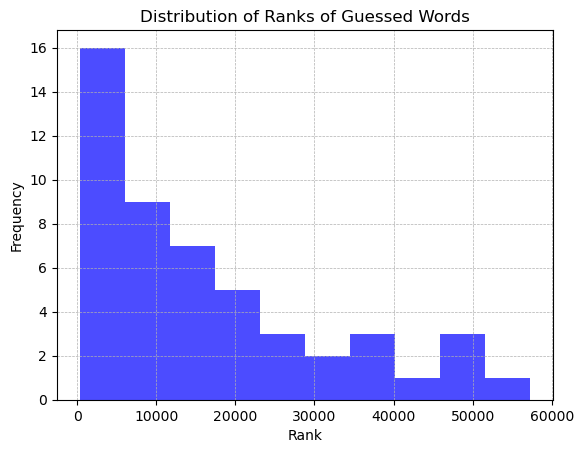

In [ ]:
def llama_chat(messages, model="llama3.2"):
    url = "http://localhost:11434/api/chat"
    try:
        response = requests.post(
            url,
            json={
                "model": model,
                "messages": messages,
                "stream": False,
                "options": {
                    "temperature": 0.6,
                    "top_p": 0.9,
                    "repeat_penalty": 1.3,
                    "stop": ["\n"],
                    "num_predict": 25  # similar to max_tokens
                }
            }
        )
        data = response.json()
        if "message" in data and "content" in data["message"]:
            return data["message"]["content"]
        else:
            print("Unexpected response format:", data)
            return None
    except Exception as e:
        print("Error calling LLaMA backend:", e)
        return None


llm_response = llama_chat([
    {"role": "system", "content": description},
    {"role": "user", "content": prompt}
])

In [ ]:
round_data = {
    "round": int(a),
    "prompt": str(prompt),
    "response_raw": str(response),
    "guesses": [str(g) for g in guess_list],
    "answer": str(answer),
    "previous_guesses": [str(g) for g in previous_guesses],
    "similarities": [float(s) for s in previous_guesses_sim],
    "ranks": [int(r) if r != -1 else None for r in previous_guesses_percentile],
    "num_guesses": len(guess_list),
    "repeated_guesses": len(guess_list) - len(set(guess_list)),
}

# save json data to file
with open('semantle_round_data.json', 'a') as f:
    json.dump(round_data, f)
    f.write('\n')  # Add a newline for readability

Number of games played: 200
Number of wins under 50 guesses: 14
Number of wins under 100 guesses: 19
Number of games with wins: 22
Number of games with losses: 178
Average number of guesses (wins only): 51.36
Average number of guesses (wins + losses): 88.03
Standard deviation of guesses (wins only): 30.35
Standard deviation of guesses (wins + losses): 19.93
Median number of guesses (wins only): 44.50
Median number of guesses (wins + losses): 88.50
Minimum number of guesses: 6
Maximum number of guesses: 142


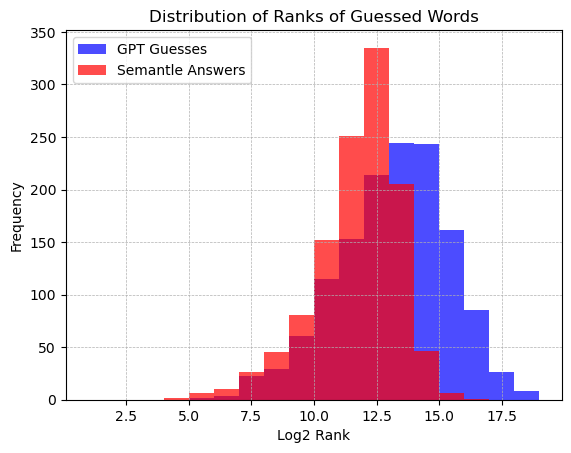

In [8]:
# read info from semantle_logs/semantle_game_{game_id}.json for game_id 0-199.
# for each game, print the number of games with wins, and average number of guesses for wins and losses.
avg_guesses_list = []
words_guessed = set()
avg_guesses_wins_list = []
avg_guesses_losses_list = []
for game_id in range(200):
  filename = f"semantle_logs/semantle_game_{game_id}.json"
  if os.path.exists(filename):
    with open(filename, 'r') as f:
      game_data = json.load(f)
      avg_guesses_list.append(game_data['total_guesses'])
      for guess in game_data['guesses']:
        words_guessed.add(guess['word'])
      if game_data['found']:
        avg_guesses_wins_list.append(game_data['total_guesses'])
      else:
        avg_guesses_losses_list.append(game_data['total_guesses'])

# print the number of games with wins, and average number of guesses for wins and losses.
num_wins = len(avg_guesses_wins_list)
avg_guesses_wins = sum(avg_guesses_wins_list) / num_wins if num_wins > 0 else 0
avg_guesses = sum(avg_guesses_list) / len(avg_guesses_list) if len(avg_guesses_list) > 0 else 0
stdev_guesses_wins = np.std(avg_guesses_wins_list) if num_wins > 0 else 0
stdev_guesses = np.std(avg_guesses_list) if len(avg_guesses_list) > 0 else 0
median_guesses_wins = np.median(avg_guesses_wins_list) if num_wins > 0 else 0
median_guesses = np.median(avg_guesses_list)
min_guesses = min(avg_guesses_list) if len(avg_guesses_list) > 0 else 0
max_guesses = max(avg_guesses_list) if len(avg_guesses_list) > 0 else 0
wins_under_50 = len([x for x in avg_guesses_wins_list if x < 50])
wins_under_100 = len([x for x in avg_guesses_wins_list if x < 100])

print(f"Number of games played: {len(avg_guesses_list)}")
print(f"Number of wins under 50 guesses: {wins_under_50}")
print(f"Number of wins under 100 guesses: {wins_under_100}")
print(f"Number of games with wins: {num_wins}")
print(f"Number of games with losses: {len(avg_guesses_losses_list)}")
print(f"Average number of guesses (wins only): {avg_guesses_wins:.2f}")
print(f"Average number of guesses (wins + losses): {avg_guesses:.2f}")
print(f"Standard deviation of guesses (wins only): {stdev_guesses_wins:.2f}")
print(f"Standard deviation of guesses (wins + losses): {stdev_guesses:.2f}")
print(f"Median number of guesses (wins only): {median_guesses_wins:.2f}")
print(f"Median number of guesses (wins + losses): {median_guesses:.2f}")
print(f"Minimum number of guesses: {min_guesses}")
print(f"Maximum number of guesses: {max_guesses}")

# plot the rank of guessed words
guesses_freq = []
for word in words_guessed:
  try:
    rank = np.log2(word_freq[word_freq['word'] == word].index[0] + 1)
    guesses_freq.append(rank)
  except IndexError:
    continue

plt.hist(guesses_freq, bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19], color='blue', label='GPT Guesses', alpha=0.7)
plt.hist(semantle_df['log_rank'], bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17], color='red', label='Semantle Answers', alpha=0.7)
plt.title('Distribution of Ranks of Guessed Words')
plt.xlabel('Log2 Rank')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [30]:
print(len(words_guessed))

1457
